In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics 
#from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from scipy.stats import randint

## DATA PREPROCESSING ##

<h3 align="center">Load Data</h3>

In [2]:
KSI_df= pd.read_csv('TOTAL_KSI_USE.csv',index_col=0)

In [3]:
KSI_df.info()
# remove trailing spaces from column names 
KSI_df.columns = KSI_df.columns.str.strip()

<class 'pandas.core.frame.DataFrame'>
Index: 4739 entries, 14218 to 18956
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               4739 non-null   object 
 1   STREET1            4739 non-null   object 
 2   STREET2            4293 non-null   object 
 3   DISTRICT           4524 non-null   object 
 4   LATITUDE           4739 non-null   float64
 5   LONGITUDE          4739 non-null   float64
 6   TRAFFCTL           4693 non-null   object 
 7   VISIBILITY         4717 non-null   object 
 8   LIGHT              4735 non-null   object 
 9   RDSFCOND           4717 non-null   object 
 10  ACCLASS            4738 non-null   object 
 11  IMPACTYPE          4712 non-null   object 
 12  INVTYPE            4730 non-null   object 
 13  INVAGE             4739 non-null   object 
 14  INJURY             2690 non-null   object 
 15  NEIGHBOURHOOD_158  4739 non-null   object 
dtypes: float64(2), object(14

<h3 align="center">Drop Column</h3>

In [4]:
# Convert to Datetime
KSI_df= KSI_df.drop('DATE', axis =1)

<h3 align="center">Checking for Missing Values</h3>

In [5]:
# Assess the percentage of null values
null_values = round((KSI_df.isnull().sum()/KSI_df.shape[0])*100,4)
null_values

STREET1               0.0000
STREET2               9.4113
DISTRICT              4.5368
LATITUDE              0.0000
LONGITUDE             0.0000
TRAFFCTL              0.9707
VISIBILITY            0.4642
LIGHT                 0.0844
RDSFCOND              0.4642
ACCLASS               0.0211
IMPACTYPE             0.5697
INVTYPE               0.1899
INVAGE                0.0000
INJURY               43.2370
NEIGHBOURHOOD_158     0.0000
dtype: float64

<h3 align="center">Check Duplicates</h3>

In [6]:
#Check for duplicate values
total_duplicates = KSI_df.duplicated().head(18957).sum()
print("The total number of duplicated rows are:", total_duplicates)

The total number of duplicated rows are: 111


<h3 align="center">Drop Duplicates</h3>

In [7]:
#Remove duplicated values
KSI_df = KSI_df.drop_duplicates()
total_duplicates = KSI_df.duplicated().head(18957).sum()
print("The total number of duplicated rows are:", total_duplicates)

The total number of duplicated rows are: 0


<h3 align="center">Assess Skewness</h3>

In [8]:
#Check if numerical columns are normal
num_col = [col for col in KSI_df.columns if (KSI_df[col].dtype != 'object')& (KSI_df[col].dtype != 'datetime64[ns]') ]
skew = KSI_df[num_col].skew()

print('The skewness for numerical colums are:', skew)

The skewness for numerical colums are: LATITUDE     0.256617
LONGITUDE    0.114678
dtype: float64


**No columns are skewed given its less than 0.5**

<h3 align="center">Visualizing Skewness</h3>

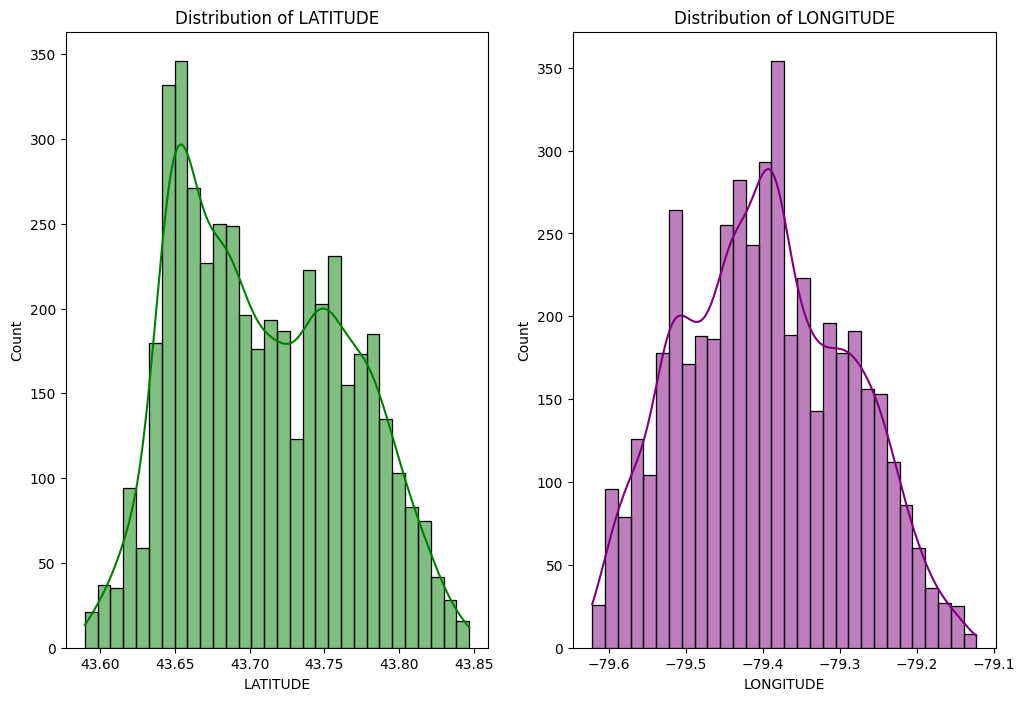

In [9]:
fig,axes = plt.subplots(1, 2,figsize=(12, 8)) 

#Create a histogram for the entire DataFrame
sns.histplot(KSI_df['LATITUDE'],ax=axes[0],kde=True, color='green', bins=30).set_title('Distribution of LATITUDE')
sns.histplot(KSI_df['LONGITUDE'],ax=axes[1],kde=True, color='purple', bins=30).set_title('Distribution of LONGITUDE')


# Show the plot
plt.show()

<h3 align="center">Check for Outliers</h3>

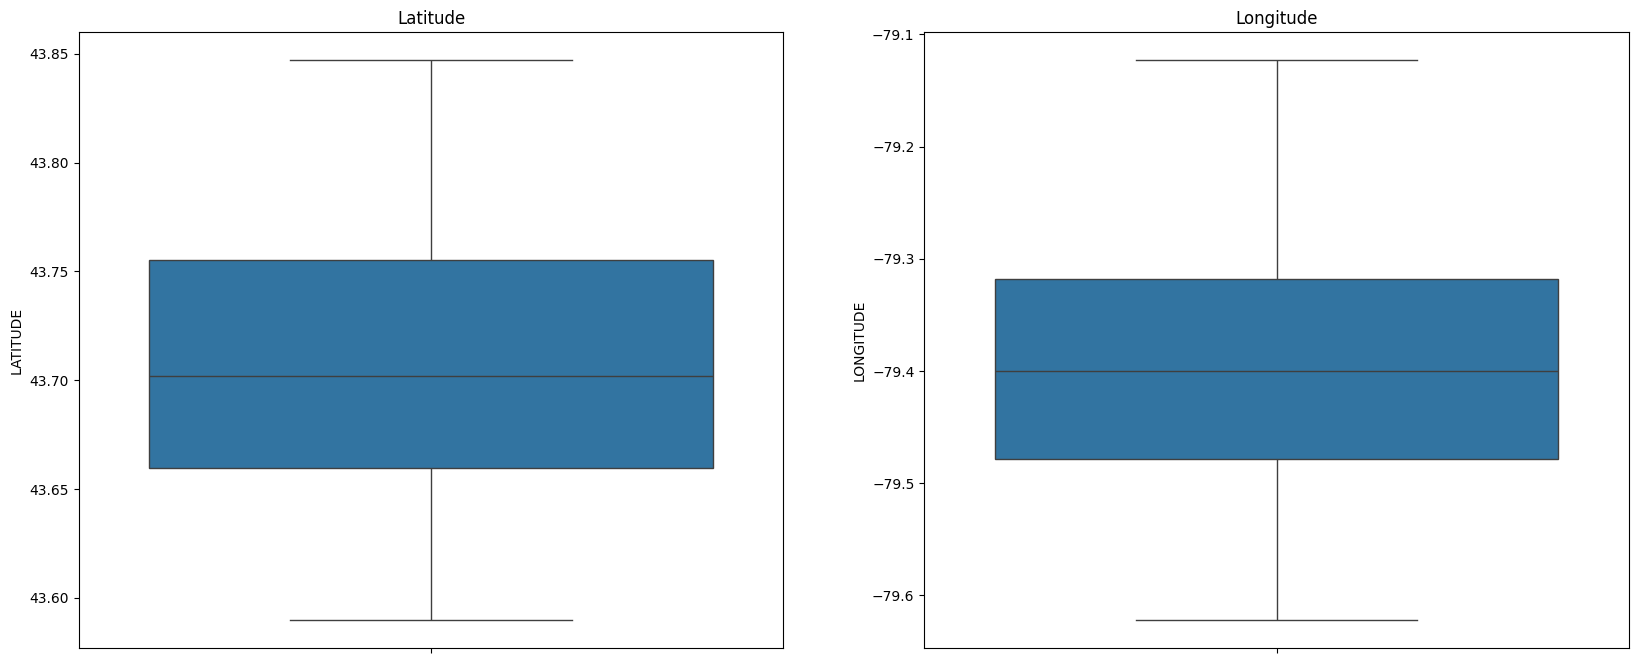

In [10]:
#Check for Outliers
fig, axes = plt.subplots(1, 2,figsize=(20, 8)) 

#Create a box plot for the entire DataFrame
sns.boxplot(KSI_df['LATITUDE'],ax=axes[0]).set_title('Latitude')
sns.boxplot(KSI_df['LONGITUDE'],ax=axes[1]).set_title('Longitude')

# Show the plot
plt.show()

## FEATURE ENGINEERING ##

<h3 align="center">Modal Imputation</h3>

In [11]:
#For object columns with null values, do modal imputation using Simple Imputer
obj_col = [col for col in KSI_df.columns if KSI_df[col].dtype == 'object']

# The Imputer object uses the mode strategy as data is categorical
imputer = SimpleImputer(strategy ='most_frequent')

# Fitting the data to the imputer object
KSI_df[obj_col] = imputer.fit_transform(KSI_df[obj_col])

<h3 align="center">Check Missing Values After Imputation</h3>

In [12]:
# Assess the percentage of null values
null_values = round((KSI_df.isnull().sum()/KSI_df.shape[0])*100,4)
null_values

STREET1              0.0
STREET2              0.0
DISTRICT             0.0
LATITUDE             0.0
LONGITUDE            0.0
TRAFFCTL             0.0
VISIBILITY           0.0
LIGHT                0.0
RDSFCOND             0.0
ACCLASS              0.0
IMPACTYPE            0.0
INVTYPE              0.0
INVAGE               0.0
INJURY               0.0
NEIGHBOURHOOD_158    0.0
dtype: float64

<h3 align="center">One Hot Encoding</h3>

In [13]:
#Identify all independent variables
independent_variables = [col for col in KSI_df.columns if col != 'NEIGHBOURHOOD_158']

#Onehot encoding for independent variables only
KSI_df = pd.get_dummies(KSI_df, columns= independent_variables,drop_first=True)

#Identify dummy columns and convert boolean values to integers
dummy_col = [col for col in KSI_df.columns if KSI_df[col].dtype == 'bool']
KSI_df[dummy_col] = KSI_df[dummy_col].astype(int)




In [14]:
KSI_df.head(5)

,NEIGHBOURHOOD_158,STREET1_100 MCLEVIN AVE,STREET1_1035 SHEPPARD AVE W,STREET1_106 BEECH AVE,STREET1_106 LAWRENCE AVE E,STREET1_107 THE QUEENSWAY,STREET1_1085 ROYAL YORK RD,STREET1_109 DOWNSVIEW AVE,STREET1_1100 QUEEN ST W,STREET1_111 BOND ST,...,INVAGE_70 to 74,INVAGE_75 to 79,INVAGE_80 to 84,INVAGE_85 to 89,INVAGE_90 to 94,INVAGE_Over 95,INVAGE_unknown,INJURY_Major,INJURY_Minimal,INJURY_Minor
14218,Leaside-Bennington,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14219,Malvern East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14220,Malvern East,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
14223,Malvern East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14224,Malvern East,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## RANDOM FOREST CLASSIFIER MODEL ##

<h3 align="center">Train, Validation and Test Split</h3>

In [15]:
#Identify all independent variables
independent_variables = [col for col in KSI_df.columns if col != 'NEIGHBOURHOOD_158']

#Independent variables
X = KSI_df[independent_variables]

#Dependent variable
y = KSI_df['NEIGHBOURHOOD_158']

# 80 % training data and 20% allocated to the temporary set which will be split into validation and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.30, random_state=42)

# Further split temporary set which was 30% of the original set into validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.50, random_state=42)



<h3 align="center">Hyperparameter Tuning</h3>

In [16]:
param_grid = {
    'n_estimators': [10, 50,100],  # Number of trees
    'max_depth': [3, 5,10, None],  # Maximum depth of trees
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3],
    'max_features': ['sqrt','log2',None],  # Number of features to consider
    'max_samples': [0.8],
}

random_search = RandomizedSearchCV(RandomForestClassifier(),param_grid, scoring='accuracy',random_state=10)
random_search.fit(X_train, y_train)
optimal_model = random_search.best_estimator_
print(random_search.best_estimator_)




RandomForestClassifier(max_samples=0.8, min_samples_split=3, n_estimators=10)


<h3 align="center">Model Implementation</h3>

In [17]:
# creating a RF classifier
clf = RandomForestClassifier(max_samples=0.8, min_samples_split=3, n_estimators=10,random_state= 10)
# Training the model on the training dataset
model= clf.fit(X_train, y_train)



<h3 align="center">Validation Testing</h3>

In [18]:
y_val_pred = clf.predict(X_val)

#Assess accuracy of validation set
validation_accuracy = metrics.accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {validation_accuracy:.4f}")


Validation Accuracy: 0.8300


<h3 align="center">Model Prediction</h3>

In [19]:
# Predict using the reduced test set
y_pred = clf.predict(X_test)


In [20]:
# using metrics module for accuracy calculation
print("Accuracy of Model Test:", round(metrics.accuracy_score(y_test, y_pred)*100,2),"%")


Accuracy of Model Test: 81.87 %


In [21]:
y_test = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True) 

predicted_KSI = pd.DataFrame({'Predicted':y_pred,'Test': y_test})
predicted_KSI.tail(10)

,Predicted,Test
685,Fort York-Liberty Village,Fort York-Liberty Village
686,West Humber-Clairville,West Humber-Clairville
687,Centennial Scarborough,Centennial Scarborough
688,Yonge-Eglinton,Yonge-Eglinton
689,Mimico-Queensway,Mimico-Queensway
690,Milliken,Milliken
691,St Lawrence-East Bayfront-The Islands,East Willowdale
692,Clairlea-Birchmount,Clairlea-Birchmount
693,Kensington-Chinatown,Trinity-Bellwoods
694,Mimico-Queensway,Mimico-Queensway


<h3 align="center">Model Evaluation</h3>

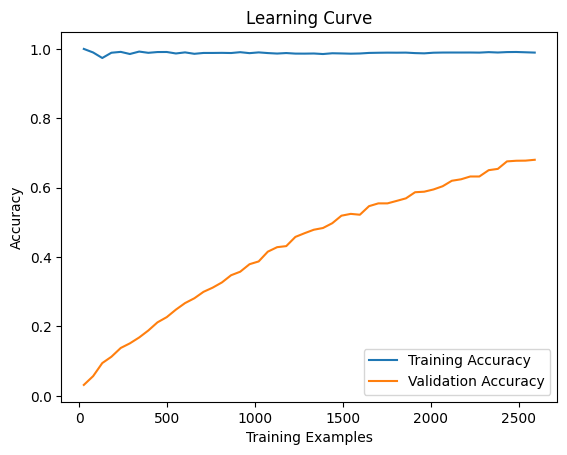

In [22]:
train_sizes, train_scores, test_scores = learning_curve(
   clf,X_train, y_train, scoring='accuracy',cv=5,train_sizes=np.linspace(0.01, 1.0, 50))
# Mean and Standard Deviation of training scores 
mean_training = np.mean(train_scores, axis=1) 
Standard_Deviation_training = np.std(train_scores, axis=1) 
  
# Mean and Standard Deviation of testing scores 
mean_testing = np.mean(test_scores, axis=1) 
Standard_Deviation_testing = np.std(test_scores, axis=1) 

plt.plot(train_sizes,mean_training, label="Training Accuracy")
plt.plot(train_sizes, mean_testing, label="Validation Accuracy")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve")
plt.show()

**This means the model does not generalize well to new data**